In [112]:
from tensorflow.keras.models import Model
from tensorflow.keras.backend import int_shape
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, Conv2DTranspose,
    MaxPooling2D, Dropout, Input, concatenate, Cropping2D, 
    SpatialDropout2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import tensorflow as tf


import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

In [107]:
# instead of:
#   from keras_unet.metrics import iou, iou_thresholded
#   from keras_unet.losses import jaccard_distance

def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [75]:
random_seed = 69

In [97]:
weights_dir = '/scratch/single_cell/EPFL/weights'

In [35]:
image_filenames = glob.glob("/scratch/single_cell/EPFL/raw/*.png")
label_filenames = glob.glob("/scratch/single_cell/EPFL/labels/data*.png")

image_filenames.sort()
label_filenames.sort()

In [134]:
# for the initial test, in order to avoid dealing with cropping afterwards
crop_shape = (512, 512)

image = image[: crop_shape[0], : crop_shape[1]]  # TODO remove later
label = label[: crop_shape[0], : crop_shape[1]]  # TODO remove later

In [145]:
images = []
labels = []

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image = imageio.imread(image_filename)
    images.append(image)
    
    label = imageio.imread(label_filename)
    labels.append(label)

images = np.array(images, dtype=np.float32) / 255.
labels = np.array(labels, dtype=np.float32) / 255.

images = np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)

print(images.min(), images.max(), "    ", labels.min(), labels.max())
print(images.shape, "    ", labels.shape)

0.007843138 1.0      0.003921569 1.0
(165, 768, 1024, 1)      (165, 768, 1024, 1)


In [146]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.5, random_state=random_seed)

In [147]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (82, 768, 1024, 1)
y_train:  (82, 768, 1024, 1)
x_val:  (83, 768, 1024, 1)
y_val:  (83, 768, 1024, 1)


In [148]:
batch_size = 32
data_gen_args = dict(
#     rotation_range=10.0,
#     # width_shift_range=0.02,
#     height_shift_range=0.02,
#     shear_range=5,
#     # zoom_range=0.3,
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode="constant",
)


In [139]:
# Train data, provide the same seed and keyword arguments to the fit and flow methods
x_datagen = ImageDataGenerator(**data_gen_args)
y_datagen = ImageDataGenerator(**data_gen_args)
x_datagen.fit(x_train, augment=True, seed=random_seed)
y_datagen.fit(y_train, augment=True, seed=random_seed)
x_train_augmented = x_datagen.flow(
    x_train, batch_size=batch_size, shuffle=True, seed=random_seed)
y_train_augmented = y_datagen.flow(
    y_train, batch_size=batch_size, shuffle=True, seed=random_seed)

train_generator = zip(x_train_augmented, y_train_augmented)

(32, 512, 512, 1) (32, 512, 512, 1)


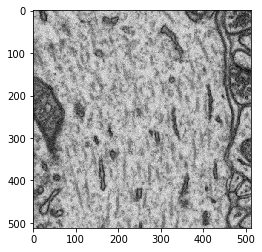

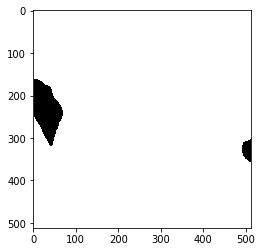

In [140]:
# check if everything looks ok

sample_batch = next(train_generator)
x_temp, y_temp = sample_batch
print(x_temp.shape, y_temp.shape)

random_example_index = np.random.randint(batch_size)

plt.imshow(x_temp[random_example_index, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_temp[random_example_index, :, :, 0], cmap='gray')
plt.show()

In [141]:
input_shape = x_temp[0].shape
num_classes = 1
dropout = 0.2
filters = 64
num_layers = 4
output_activation='sigmoid'

In [142]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [143]:
def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

In [144]:
# Build U-Net model
inputs = Input(input_shape)
x = inputs   

down_layers = []
for l in range(num_layers):
    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=False, dropout=0.0, padding='valid')
    down_layers.append(x)
    x = MaxPooling2D((2, 2), strides=2) (x)
    filters = filters*2 # double the number of filters with each layer

x = Dropout(dropout)(x)
x = conv2d_block(inputs=x, filters=filters, use_batch_norm=False, dropout=0.0, padding='valid')

for conv in reversed(down_layers):
    filters //= 2 # decreasing number of filters with each layer 
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='valid') (x)

    ch, cw = get_crop_shape(int_shape(conv), int_shape(x))
    conv = Cropping2D(cropping=(ch, cw))(conv)

    x = concatenate([x, conv])
    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=False, dropout=0.0, padding='valid')

outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)    

unet = Model(inputs=[inputs], outputs=[outputs])

unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 510, 510, 64) 640         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 508, 508, 64) 36928       conv2d_87[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 254, 254, 64) 0           conv2d_88[0][0]                  
____________________________________________________________________________________________

In [121]:
unet.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [122]:
model_version = '0.0.0.0.0_default_vanilla_unet_noaugm'

os.system('mkdir ' + weights_dir + '/weights' + model_version)

checkpointer = ModelCheckpoint(
    weights_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
    verbose=1, 
    monitor='val_loss',
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch')

history_callback = unet.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[checkpointer]
)

unet.save(weights_dir + '/unet_' + model_version + '.h5')

  ...
    to  
  ['...']


ValueError: A target array with shape (83, 768, 1024, 1) was passed for an output of shape (None, 580, 836, 1) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.